# SoundCoop Paper - Figure for Case Study 3

This Jupyter Notebook applies the analysis and creates the subsequent plot for the Case Study 3 figure in the Wall et al A Collaborative Framework to Address Big Data Challenges in Marine Passive Acoustic Monitoring paper detailing the SoundCoop project. This case study discovers dominant sound sources using blue and fin whale call indices.

The code pulls one-minute hybrid millidecade (HMD) spectra calculated for the Acoustic and Environmental Observation Network dataset (AEON5), NOAA-National Park Service Ocean Noise Reference Station Network dataset (NRS11), and Monterey Bay Aquarium Research Institute Monterey Accelerated Research System dataset (MARS). All data were recorded throughout 2021. 

AEON5 and NRS11 are hosted on the NOAA Open Data Dissemination Program Google Cloud Platform (GCP) bucket associated with the NOAA National Centers for Environmental Information Passive Acoustic Data Archive while MARS is hosted on the Amazon Web Services (AWS) Open Data Registry bucket associated with MBARI Pacific Ocean Sound Recordings. The weekly  call index (CI) was calculated for blue whale B calls and fin whale 20 Hz calls. For blue whales, the CI ratio was calculated as [42, 43 Hz] / [37, 50 Hz] where the 3rd and strongest harmonic of B calls occurs between 42 and 44 Hz, and 37 and 50 Hz represent frequency bands that would not include energy from a B call. CI was calculated for fin whale calls using [20, 21 Hz] / [12, 34 Hz]. The results are then binned to one-day resolution using the median and then aggregated further to one week resolution and plotted over time. 

NOAA OAR Pacific Marine Environmental Laboratory, Cooperative Institute for Marine Ecosystem and Resources Studies, National Marine Fisheries Service, NOS Office of National Marine Sanctuaries, and DOI NPS Natural Resource Stewardship and Science Directorate (2023). Hybrid Millidecade Spectra at 1 Minute Resolution Recorded at the Ocean Noise Reference Station Network (NRS). NOAA National Centers for Environmental Information. (https://doi.org/10.25921/tr4q-xa94).

University of New Hampshire and Office of Naval Research (2023). Hybrid Millidecade Spectra at 1 Minute Resolution Recorded at the Acoustic and Environmental Observation Network (AEON) for the Office of Naval Research. NOAA National Centers for Environmental Information. (https://doi.org/10.25921/d21t-be25).

Monterey Bay Aquarium Research Institute (2023). Hybrid Millidecade Spectra at 1 Minute Resolution Recorded at the Monterey Accelerated Research System (MARS) Cabled Observatory. NOAA National Centers for Environmental Information. (https://doi.org/10.25921/6gvv-dk87).

contact: carrie.wall@noaa.gov

## Setup

To start, we need to install the required dependencies. This notebook has been tested in Python 3.11. You only need to run this once per environment

In [1]:
import sys
sys.path = ['.'] + sys.path
!pip install pvlib
!pip install lifewatch-pypam==0.3.2
!pip install minio

## Import packages

We'll start importing all the packages we will need

In [2]:
import pathlib
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime
import re

In [3]:
from pypam.acoustic_survey import ASA
import pypam.utils
import pypam.plots

## Download the data

In [4]:
from minio import Minio
from minio.error import S3Error

from pathlib import Path
import os.path

Let's define which stations will we download and the overall start and end date for downloading

In [5]:
stations_to_download_gp = ['AEON5', 'NRS11']
stations_to_download_aws = ['MARS']
first_date = '2021-01-01'
last_date = '2022-12-31'

Here we define the local paths where we will download the data and the output from this notebook

In [6]:
# Make the main storage folder
local_path = '../../shared/data' # Change to your local path
output_path = local_path + '/figures'
if not os.path.isdir(local_path):
    Path(local_path).mkdir()

if not os.path.isdir(output_path):
    Path(output_path).mkdir()

for station in stations_to_download_gp + stations_to_download_aws:
    station_path = Path(local_path).joinpath(station)
    if not os.path.isdir(station_path):
        Path(station_path).mkdir()

In [7]:
def download_data_station(station_name, 
                          client_obj, 
                          bucket_str, 
                          prefix_str, 
                          data_path,
                          name_format,
                          start_datetime, 
                          end_datetime):
    start_datetime_obj = datetime.fromisoformat(start_datetime) 
    end_datetime_obj = datetime.fromisoformat(end_datetime)
    station_folder = pathlib.Path(data_path).joinpath(station_name)
    if not station_folder.exists():
        os.mkdir(station_folder)
    objects = list(client_obj.list_objects(bucket_str, prefix=prefix_str))
    ct = 0
    for i, obj in enumerate(objects):
        object_name = obj.object_name
        path_name = pathlib.Path(object_name).name
        if (not path_name.startswith('.')) & path_name.endswith('.nc'):
            match = re.findall(r"_(\d+)", path_name)[-1]
            file_date = datetime.strptime(match, name_format)
            # Here we filter by start and end time as all the data we will download is in the same period of time 
            if (file_date >= start_datetime_obj) & (file_date <= end_datetime_obj):
                download_path = data_path + '/' + station_name + '/' + pathlib.Path(object_name).name
                if os.path.isfile(download_path):
                    print('Already downloaded: ' + download_path)
                else:
                    print('Download ' + str(ct) + ' of ' + str(len(objects)) + ': ' + download_path)
                    object_data = client_obj.get_object(bucket_str, object_name)
                    if not os.path.isdir(download_path):
                        with open(str(download_path), 'wb') as file_data:
                            for data in object_data:
                                file_data.write(data)
                    file_data.close()
            else: 
                print('Ignored, out of selected period or not a netCDF file ' + path_name)
        ct += 1

We first define where the data are stored to be able to access it, and then we download the data

Let's start with the GCP hosted datasets

In [34]:
CLIENT = Minio('storage.googleapis.com')
BUCKET = 'noaa-passive-bioacoustic'
PREFIX = 'soundcoop'
CLIENT = Minio('storage.googleapis.com')
name_format = '%Y%m%d'
for station in stations_to_download_gp: 
    download_data_station(station, CLIENT, BUCKET, f'{PREFIX}/{station}/', local_path, name_format=name_format, start_datetime=first_date, end_datetime=last_date)

Already downloaded: ../../shared/data/AEON5/AEON5_AMAR378.1.16000_20210721_DAILY_MILLIDEC_MinRes_v2.nc
Already downloaded: ../../shared/data/AEON5/AEON5_AMAR378.1.16000_20210722_DAILY_MILLIDEC_MinRes_v2.nc
Already downloaded: ../../shared/data/AEON5/AEON5_AMAR378.1.16000_20210723_DAILY_MILLIDEC_MinRes_v2.nc
Already downloaded: ../../shared/data/AEON5/AEON5_AMAR378.1.16000_20210724_DAILY_MILLIDEC_MinRes_v2.nc
Already downloaded: ../../shared/data/AEON5/AEON5_AMAR378.1.16000_20210725_DAILY_MILLIDEC_MinRes_v2.nc
Already downloaded: ../../shared/data/AEON5/AEON5_AMAR378.1.16000_20210726_DAILY_MILLIDEC_MinRes_v2.nc
Already downloaded: ../../shared/data/AEON5/AEON5_AMAR378.1.16000_20210727_DAILY_MILLIDEC_MinRes_v2.nc
Already downloaded: ../../shared/data/AEON5/AEON5_AMAR378.1.16000_20210728_DAILY_MILLIDEC_MinRes_v2.nc
Already downloaded: ../../shared/data/AEON5/AEON5_AMAR378.1.16000_20210729_DAILY_MILLIDEC_MinRes_v2.nc
Already downloaded: ../../shared/data/AEON5/AEON5_AMAR378.1.16000_2021073

We will do the same for MARS data on AWS

In [35]:
CLIENT = Minio( "s3.us-west-2.amazonaws.com", secure=False)
BUCKET = 'pacific-sound-spectra'
PREFIX = '2021/'
name_format = '%Y%m%d'
for station in stations_to_download_aws: 
    download_data_station(station, CLIENT, BUCKET, f'{PREFIX}', local_path, name_format=name_format, start_datetime=first_date, end_datetime=last_date)

Already downloaded: ../../shared/data/MARS/MARS_20210101.nc
Already downloaded: ../../shared/data/MARS/MARS_20210102.nc
Already downloaded: ../../shared/data/MARS/MARS_20210103.nc
Already downloaded: ../../shared/data/MARS/MARS_20210104.nc
Already downloaded: ../../shared/data/MARS/MARS_20210105.nc
Already downloaded: ../../shared/data/MARS/MARS_20210106.nc
Already downloaded: ../../shared/data/MARS/MARS_20210107.nc
Already downloaded: ../../shared/data/MARS/MARS_20210108.nc
Already downloaded: ../../shared/data/MARS/MARS_20210109.nc
Already downloaded: ../../shared/data/MARS/MARS_20210110.nc
Already downloaded: ../../shared/data/MARS/MARS_20210111.nc
Already downloaded: ../../shared/data/MARS/MARS_20210112.nc
Already downloaded: ../../shared/data/MARS/MARS_20210113.nc
Already downloaded: ../../shared/data/MARS/MARS_20210114.nc
Already downloaded: ../../shared/data/MARS/MARS_20210115.nc
Already downloaded: ../../shared/data/MARS/MARS_20210116.nc
Already downloaded: ../../shared/data/MA

## Get data by station & resample the temporal resolution

We will load only a part of the data in frequency range to save some memory. 
The MARS station does not have a quality_flag variable so we need to take that into account when loading

In [8]:
min_freq = 0
max_freq = 435

In [9]:
# Only get data from 2021  and remove data with bad quality flag
def load_data_from_station_year(station, year, data_vars, freq_bounds=None):
    deployment_path = pathlib.Path(local_path).joinpath(station)
    print('loading station %s...' % station)

    aggregated_ds = pypam.utils.join_all_ds_output_deployment(deployment_path, data_vars=data_vars, datetime_coord='time',
                                                              join_only_if_contains='_%s' % year, load=True,
                                                              parallel=False, freq_band=freq_bounds,
                                                              freq_coord='frequency',
                                                              )
    if 'quality_flag' in aggregated_ds.data_vars:
        aggregated_ds['psd'] = aggregated_ds.psd.where(aggregated_ds.quality_flag.isin([1]))
        aggregated_ds = aggregated_ds.drop_vars('quality_flag')

    return aggregated_ds # this assigns an xarray dataset

<div class="alert alert-block alert-info">
⚠️ Be patient, loading full years of data can take a while...
</div>

In [10]:
# Load all the data in one dictionary
stations_to_load = ['AEON5', 'MARS', 'NRS11'] # Make a list of stations to compare
ds_collection = {}
for station in stations_to_load:
    if 'MARS' in stations_to_load:
        ds_collection[station] = load_data_from_station_year(station, 2021, data_vars=['psd'], freq_bounds=[min_freq, max_freq])
    else: 
        ds_collection[station] = load_data_from_station_year(station, 2021, data_vars=['psd', 'quality_flag'], freq_bounds=[min_freq, max_freq])

loading station AEON5...
[########################################] | 100% Completed | 15.10 ss
loading station MARS...
[########################################] | 100% Completed | 29.39 s
loading station NRS11...
[########################################] | 100% Completed | 17.54 s


## Whale presence indices

Indices are the ratio of mean power spectral density (PSD) within the frequency band of peak call energy to mean PSD at background frequencies.
These peak and background frequencies will be illustrated in the summary plot and call index calculations below

In [11]:
# Define the frequencies that are used to compute call indices
bluepeak = np.array([42, 43])
finpeak = np.array([20, 21])
bluebackground = np.array([37, 50])
finbackground = np.array([12, 34])

In [12]:
whale_station1 = 'AEON5' 
whale_station2 = 'NRS11' 
whale_station3 = 'MARS'

In [13]:
def compute_whale_index(peak, background, daily_ds):
    pk = daily_ds.sel(frequency=peak).psd.mean(dim='frequency')
    bg = daily_ds.sel(frequency=background).psd.mean(dim='frequency')
    CI = pk / bg
    CI = CI.resample(time='1D').median()  # Resample to daily spectra
    return CI

Let's compute the call indices per station and whale species

In [14]:
# Compute the whale indices
finCI1 = compute_whale_index(finpeak, finbackground, ds_collection[whale_station1])
blueCI1 = compute_whale_index(bluepeak, bluebackground, ds_collection[whale_station1])
finCI2 = compute_whale_index(finpeak, finbackground, ds_collection[whale_station2])
blueCI2 = compute_whale_index(bluepeak, bluebackground, ds_collection[whale_station2])
finCI3 = compute_whale_index(finpeak, finbackground, ds_collection[whale_station3])
blueCI3 = compute_whale_index(bluepeak, bluebackground, ds_collection[whale_station3])

Here we resample the data by week and calculate the 25th, 50th (median), and 75th percentiles

In [15]:
date_range1 = blueCI1.time.values
time_series1 = pd.Series(blueCI1, index=date_range1)

date_range2 = blueCI2.time.values
time_series2 = pd.Series(blueCI2, index=date_range2)

date_range3 = blueCI3.time.values
time_series3 = pd.Series(blueCI3, index=date_range3)

# Resample the data by week and calculate percentiles
weekly1 = time_series1.resample('W').agg(['median', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)])
weekly1.columns = ['median', '25th_percentile', '75th_percentile']

weekly2 = time_series2.resample('W').agg(['median', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)])
weekly2.columns = ['median', '25th_percentile', '75th_percentile']

weekly3 = time_series3.resample('W').agg(['median', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)])
weekly3.columns = ['median', '25th_percentile', '75th_percentile']

In [16]:
sns.set_theme(style='ticks')

Here we plot and save the results.

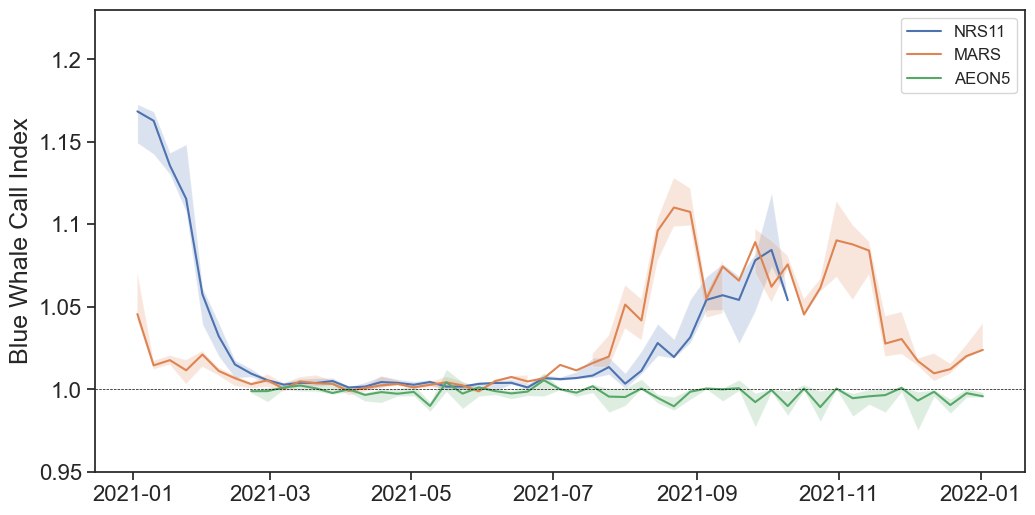

In [17]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif"
})

# Plot the results
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(weekly2.index, weekly2['median'], label='NRS11') #, color='blue'
ax.fill_between(weekly2.index, 
                weekly2['25th_percentile'], 
                weekly2['75th_percentile'], 
                alpha=0.2)

ax.plot(weekly3.index, weekly3['median'], label='MARS') 
ax.fill_between(weekly3.index, 
                weekly3['25th_percentile'], 
                weekly3['75th_percentile'], 
                alpha=0.2) 
ax.plot(weekly1.index, weekly1['median'], label='AEON5') #, color='blue'
ax.fill_between(weekly1.index, 
                weekly1['25th_percentile'], 
                weekly1['75th_percentile'], 
                alpha=0.2) # color='blue', alpha=0.2, label='25th-75th Percentile Range')

# Set face color to white
ax.set_ylim(0.95, 1.23) #ax.set_ylim(1, 1.2)

plt.yticks([0.95, 1, 1.05, 1.1, 1.15, 1.2], ['0.95', '1.0', '1.05', '1.1', '1.15','1.2']) 

ax.axhline(1,color='black',linestyle='--',linewidth=0.5)

# Add titles and labels
# #plt.title('Weekly Blue Whale Call Index')
# #plt.xlabel('2021')
plt.ylabel('Blue Whale Call Index', fontsize=18)

# Set the font size of x-tick labels
ax.tick_params(axis='x', labelsize=16)

# Set the font size of y-tick labels (optional)
ax.tick_params(axis='y', labelsize=16)

plt.legend(fontsize=12,loc = "upper right")

# Show the plot
plt.show()

# Save the plot
fig.savefig(output_path+ '/SoundCoopPaper-CaseStudy3-weeklyBlueWhale.png') # save as png

In [18]:
#Weekly fin whale calculations

date_range1 = finCI1.time.values
time_series1 = pd.Series(finCI1, index=date_range1)

date_range2 = finCI2.time.values
time_series2 = pd.Series(finCI2, index=date_range2)

date_range3 = finCI3.time.values
time_series3 = pd.Series(finCI3, index=date_range3)

# Resample the data by month and calculate percentiles
weekly1Fin = time_series1.resample('W').agg(['median', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)])
weekly1Fin.columns = ['median', '25th_percentile', '75th_percentile']

weekly2Fin = time_series2.resample('W').agg(['median', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)])
weekly2Fin.columns = ['median', '25th_percentile', '75th_percentile']

weekly3Fin = time_series3.resample('W').agg(['median', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)])
weekly3Fin.columns = ['median', '25th_percentile', '75th_percentile']

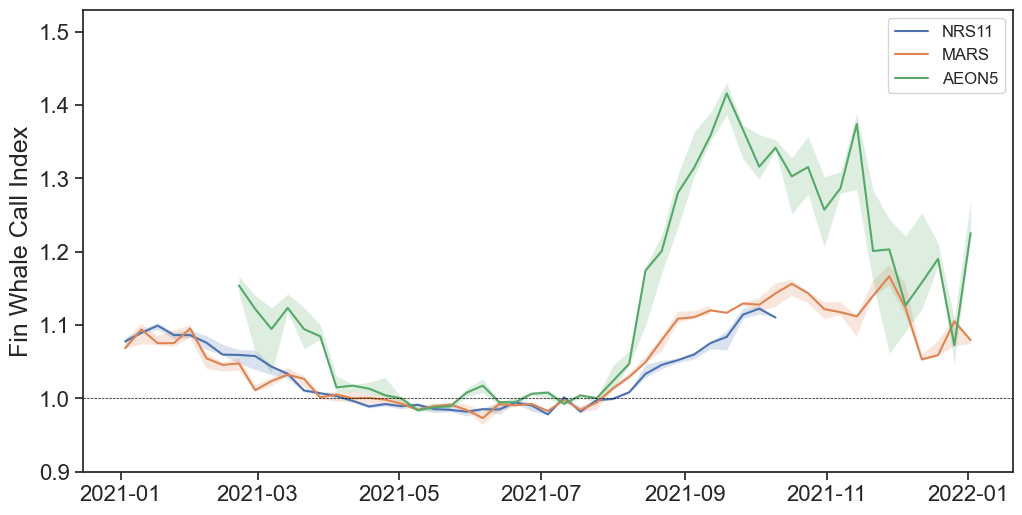

In [19]:
# Plot the results
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(weekly2Fin.index, weekly2Fin['median'], label='NRS11') 
ax.fill_between(weekly2Fin.index, 
                weekly2Fin['25th_percentile'], 
                weekly2Fin['75th_percentile'], 
                alpha=0.2)

ax.plot(weekly3Fin.index, weekly3Fin['median'], label='MARS') 
ax.fill_between(weekly3Fin.index, 
                weekly3Fin['25th_percentile'], 
                weekly3Fin['75th_percentile'], 
                alpha=0.2) 
ax.plot(weekly1Fin.index, weekly1Fin['median'], label='AEON5') 
ax.fill_between(weekly1Fin.index, 
                weekly1Fin['25th_percentile'], 
                weekly1Fin['75th_percentile'], 
                alpha=0.2) 

# Set face color to white
ax.set_facecolor('white')
ax.set_ylim(0.90, 1.53) #ax.set_ylim(1, 1.5)

ax.axhline(1,color='black',linestyle='--',linewidth=0.5)

# Add titles and labels
plt.ylabel('Fin Whale Call Index', fontsize=18)

# Set the font size of x-tick labels
ax.tick_params(axis='x', labelsize=16)

# Set the font size of y-tick labels (optional)
ax.tick_params(axis='y', labelsize=16)

plt.legend(fontsize=12)

# Show the plot
plt.show()

# Save the plot
fig.savefig(output_path+ '/SoundCoopPaper-CaseStudy3-weeklyFinWhale.png') # save as png